In [1]:
import carla
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import deque

In [2]:
# Connect to the server
# 连接服务器
client = carla.Client('127.0.0.1', 2000)
client.set_timeout(10.0)
world = client.load_world('Town01')
traffic_manager = client.get_trafficmanager(8000)
town_map = world.get_map()


In [7]:
import pickle

spawn_points = town_map.get_spawn_points()
spawn_points = [(x.location.x, x.location.y, x.location.z, x.rotation.yaw, x.rotation.pitch, x.rotation.roll) for x in spawn_points]
with open('../map_cache/Town01_spawn_points.pkl', 'wb') as f:
    pickle.dump(spawn_points, f)



In [ ]:
spawn_point_inst = carla.Transform(carla.Location(x=spawn_points[0][0], y=spawn_points[0][1], z=spawn_points[0][2]), carla.Rotation(yaw=spawn_points[0][3], pitch=spawn_points[0][4], roll=spawn_points[0][5]))

In [ ]:
# segment_waypoints_list = town_map.generate_waypoints(5.0)
# for waypoint in segment_waypoints_list:
#     # 画出车道线
#     if waypoint.is_junction:
#         plt.plot(waypoint.transform.location.x, waypoint.transform.location.y, 'bo', markersize=0.1)
#     else:
#         plt.plot(waypoint.transform.location.x, waypoint.transform.location.y, 'ro', markersize=0.1)
    

# plt.show()

In [ ]:
# 存下waypoints
# import pickle

# waypoints_list = []
# for waypoint in waypoints:
#     waypoints_list.append([waypoint.transform.location.x, waypoint.transform.location.y, waypoint.transform.location.z])

# with open('town01_waypoints.pkl', 'wb') as f:
#     pickle.dump(waypoints_list, f)

In [ ]:
# import pickle
# with open('town01_waypoints.pkl', 'rb') as f:
#     waypoints_list = pickle.load(f)

# for waypoint in waypoints_list:
#     plt.plot(waypoint[0], waypoint[1], 'ro', markersize=0.1)

# landmarks = town_map.get_all_landmarks()
# for landmark in landmarks:
#     # 画出地标
#     plt.plot(landmark.transform.location.x, landmark.transform.location.y, 'bo', markersize=0.1)
#     # print('landmark:', landmark.transform.location.x, landmark.transform.location.y, landmark.transform.location.z)

# plt.show()

In [3]:
import random

# 生成随机的初始位置
spawn_points = town_map.get_spawn_points()
spawn_points_len = len(spawn_points)
seed = random.randint(0, spawn_points_len-1)
spawn_point = spawn_points[seed]
print('spawn_points:', spawn_point.location.x, spawn_point.location.y, spawn_point.location.z)

spawn_points: 202.5500030517578 59.33001708984375 0.29999998211860657


In [4]:
def get_all_segment_lanes(curr_waypoint: int, interval: int = 1, total_search_depth: int = 100, segment_waypoints_num: int = 10):

    segment_lanes_list = []
    breakpoint_queue = deque()

    def get_segment_lane(curr_waypoint, towards, interval, search_depth, segment_waypoints_num):
        '''
        @param curr_waypoint: 当前车道的waypoint
        @param towards: 方向，'next'表示向前，'previous'表示向后
        @param interval: 距离间隔
        @param num: 生成的waypoints的数量
        @return: 返回生成的waypoints, np.array
        '''

        nonlocal breakpoint_queue
        segment_waypoints_list = []
        next_waypoint = curr_waypoint

        for i in range(search_depth):
            if towards == 'next':
                next_waypoint_list = next_waypoint.next(interval)
            elif towards == 'previous':
                next_waypoint_list = next_waypoint.previous(interval)
            
            next_waypoint_list_len = len(next_waypoint_list)
            if next_waypoint_list is None:
                break
            elif next_waypoint_list_len > 1 or i == segment_waypoints_num:
                breakpoint_queue += list(zip(next_waypoint_list, [search_depth-i]*next_waypoint_list_len))
                break
            elif next_waypoint_list_len == 1:
                # segment_waypoints_list.append([next_waypoint.transform.location.x, next_waypoint.transform.location.y, next_waypoint.transform.location.z])
                # is_turn_left_allowed = next_waypoint.lane_change == carla.libcarla.LaneChange.Left or next_waypoint.lane_change == carla.libcarla.LaneChange.Both
                # is_turn_right_allowed = next_waypoint.lane_change == carla.libcarla.LaneChange.Right or next_waypoint.lane_change == carla.libcarla.LaneChange.Both
                vec_forward = next_waypoint.transform.get_forward_vector()
                vec_right = next_waypoint.transform.get_right_vector()
                lane_width = next_waypoint.lane_width
                segment_waypoints_list.append([
                    next_waypoint.transform.location.x, next_waypoint.transform.location.y,     # 0:2 # x, y
                    vec_forward.x, vec_forward.y,                                               # 2:4 # vec_forward
                    total_search_depth - search_depth + i,                                      # 4 # depth
                    int(next_waypoint.is_junction),                                             # 5 # is_junction
                    lane_width,                                                                 # 6 # lane_width
                    vec_right.x, vec_right.y])                                                  # 7:9 # vec_right
                if towards == 'next':
                    next_waypoint = next_waypoint.next(interval)[0]
                elif towards == 'previous':
                    next_waypoint = next_waypoint.previous(interval)[0]

        # 处理收集的一小段车道的 waypoints
        len_waypoints = len(segment_waypoints_list)
        segment_waypoints_list = np.array(segment_waypoints_list)

        if len_waypoints < segment_waypoints_num and len_waypoints > 0:
            segment_waypoints_list = np.concatenate((segment_waypoints_list, np.tile(segment_waypoints_list[-1], (segment_waypoints_num-len_waypoints, 1))), axis=0)  # 用最后一个waypoint填充
        elif len_waypoints == 0:
            segment_waypoints_list = None
            
        return segment_waypoints_list
    
    breakpoint_queue.append((curr_waypoint, total_search_depth))
    while breakpoint_queue:
        (satrt_waypoint, num) = breakpoint_queue.popleft()
        next_lane_waypoints = get_segment_lane(satrt_waypoint, 'next', interval, num, segment_waypoints_num)
        # previous_lane_waypoints = get_lane_waypoints(curr_waypoint, 'previous', interval, num)

        if next_lane_waypoints is not None:
            segment_lanes_list.append(next_lane_waypoints)
        # if previous_lane_waypoints is not None:
        #     seperate_lanes.append(previous_lane_waypoints)

    breakpoint_queue.append((curr_waypoint, total_search_depth))
    while breakpoint_queue:
        (satrt_waypoint, num) = breakpoint_queue.popleft()
        # next_lane_waypoints = get_lane_waypoints(curr_waypoint, 'next', interval, num)
        previous_lane_waypoints = get_segment_lane(satrt_waypoint, 'previous', interval, num, segment_waypoints_num)

        # if next_lane_waypoints is not None:
        #     seperate_lanes.append(next_lane_waypoints)
        if previous_lane_waypoints is not None:
            segment_lanes_list.append(previous_lane_waypoints)

    return segment_lanes_list

ego: Driving
left: Driving
right: Shoulder
time: 0.009255170822143555
5.0
25.0
45.0
65.0
85.0
5.0
25.0
39.0
39.0
59.0
59.0
79.0
79.0
90.0
90.0
95.0
99.0
99.0


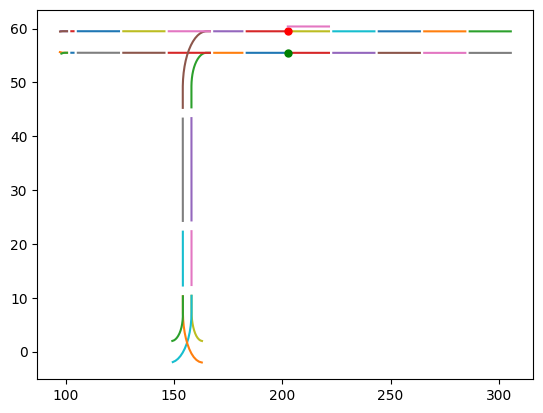

In [6]:
distance = 1
search_depth = 100
segment_waypoints_num = 20

ego_location = spawn_point.location
ego_waypoint = town_map.get_waypoint(ego_location)
left_lane_waypoint = ego_waypoint.get_left_lane()
right_lane_waypoint = ego_waypoint.get_right_lane()
print('ego:', ego_waypoint.lane_type)
print('left:', left_lane_waypoint.lane_type)
print('right:', right_lane_waypoint.lane_type)

if left_lane_waypoint.lane_type == carla.libcarla.LaneType.Driving:
    time_start = time.time()
    left_lanes = get_all_segment_lanes(left_lane_waypoint, interval=distance,
                                       total_search_depth=search_depth, segment_waypoints_num=segment_waypoints_num)
    print('time:', time.time()-time_start)
    for lane in left_lanes:
        plt.plot(lane[:, 0], lane[:, 1], markersize=0.1)
    plt.plot(left_lane_waypoint.transform.location.x,
             left_lane_waypoint.transform.location.y, 'go', markersize=5)


if right_lane_waypoint.lane_type == carla.libcarla.LaneType.Driving:
    right_lanes = get_all_segment_lanes(right_lane_waypoint, interval=distance,
                                        total_search_depth=search_depth, segment_waypoints_num=segment_waypoints_num)

    for lane in right_lanes:
        plt.plot(lane[:, 0], lane[:, 1], markersize=0.1)
    plt.plot(right_lane_waypoint.transform.location.x,
             right_lane_waypoint.transform.location.y, 'bo', markersize=5)

ego_lane_waypoints = get_all_segment_lanes(
    ego_waypoint, interval=distance, total_search_depth=search_depth, segment_waypoints_num=segment_waypoints_num)
for lane in ego_lane_waypoints:
    plt.plot(lane[:, 0], lane[:, 1], markersize=0.1)
plt.plot(ego_waypoint.transform.location.x,
         ego_waypoint.transform.location.y, 'ro', markersize=5)


def lateral_shift(origin, right_vec, shift):
    right_vec_normalized = right_vec / np.linalg.norm(right_vec)
    shifted_point = origin + right_vec_normalized * shift
    return shifted_point


example_lane = ego_lane_waypoints[0]
lane_width = example_lane[0][6]
shift_lane = lateral_shift(
    example_lane[:, 0:2], example_lane[:, 7:9], lane_width)
plt.plot(shift_lane[:, 0], shift_lane[:, 1], markersize=0.1)